In [1]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from tqdm import tqdm

In [2]:
labels_dir = './data/BDD100K/labels'
images_dir = './data/BDD100K/100k_images_val/images'
train_label_file = 'det_val.json'

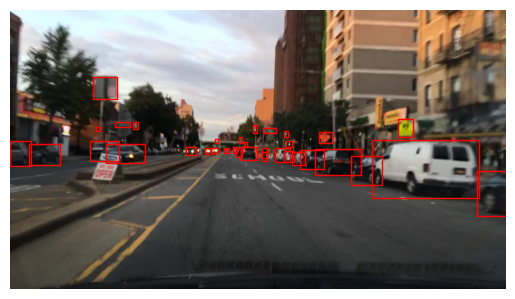

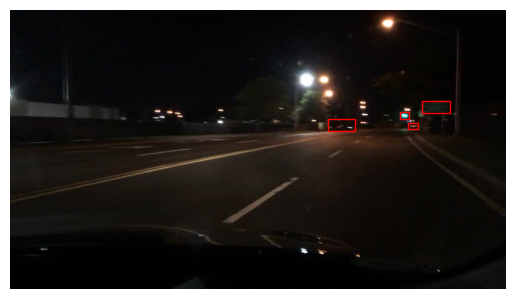

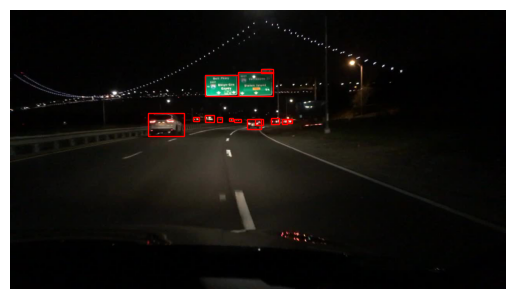

In [3]:
# Read the labels file
with open(os.path.join(labels_dir, train_label_file), 'r') as file:
    label_data = json.load(file)

# Function to plot a single image with bounding boxes
def plot_image_with_boxes(image_path, labels):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for label in labels:
        box = label['box2d']
        x1, y1, x2, y2 = box['x1'], box['y1'], box['x2'], box['y2']
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.axis('off')
    plt.show()

# Plot the first three images with their bounding boxes
for image_data in label_data[:3]:
    image_path = os.path.join(images_dir, image_data['name'])
    plot_image_with_boxes(image_path, image_data['labels'])

In [5]:
class BDD100KDataset(Dataset):
    def __init__(self, label_data, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.data = []

        for item in label_data:
            image_path = os.path.join(self.images_dir, item['name'])
            try:
                for label in item['labels']:
                    if self.is_erroneous(label):
                        label_status = 1  # erroneous
                    else:
                        label_status = 0  # normal

                    # Store image path and label status separately
                    self.data.append((image_path, label_status, label['box2d']))
            except:
                pass

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, label_status, box = self.data[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Convert box dict to tensor
        box_tensor = torch.tensor([box['x1'], box['y1'], box['x2'], box['y2']], dtype=torch.float32)
        
        return image, box_tensor, label_status

    @staticmethod
    def is_erroneous(label):
        # Return True if the label is considered erroneous, False otherwise
        return label.get('attributes', {}).get('occluded', False)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset = BDD100KDataset(label_data, images_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=1024, shuffle=True)

In [5]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.resnet = models.resnet18(weights='ResNet18_Weights.DEFAULT')
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.fc = nn.Linear(1000, 1)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.sigmoid(self.fc(x))
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
model = SimpleCNN().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), lr=0.001)
print(len(dataloader))

model.train()
for epoch in range(10):
    with tqdm(dataloader, unit="batch") as tepoch:
        for images, boxes, labels in tepoch:
            tepoch.set_description(f"Epoch {epoch}")

            images = images.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            tepoch.set_postfix(loss=loss.item())

Device: cuda
182


Epoch 0:  32%|███▏      | 58/182 [23:06<52:26, 25.37s/batch, loss=0.693]  